# **Load OpenAI and Tavily Search API Keys**

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

# **Import Required Libraries**

In [ ]:
from typing import Annotated, Sequence, TypedDict, Literal, Union, List, Tuple, Dict
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, ToolMessage, AIMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
import operator

# **Create Tools**

In [ ]:
tv_search = TavilySearchResults(max_results=5, search_depth='advanced', max_tokens=10000)

@tool
def kaggle_dataset_search(query: str) -> str:
    """Search for relevant datasets on Kaggle"""
    # Using Tavily to search Kaggle specifically
    return tv_search.invoke(f"site:kaggle.com datasets {query}")

@tool
def huggingface_search(query: str) -> str:
    """Search for relevant datasets on HuggingFace"""
    # Using Tavily to search HuggingFace specifically
    return tv_search.invoke(f"site:huggingface.co {query}")

@tool
def github_search(query: str) -> str:
    """Search for relevant repositories on GitHub"""
    # Using Tavily to search GitHub specifically
    return tv_search.invoke(f"site:github.com {query}")

# **Graph State**

In [ ]:
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

# **Create Agents**

In [ ]:
# Create Agents
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

industry_research_prompt = ChatPromptTemplate.from_messages([
    ("system", f"""You are an Industry Research Specialist AI assistant.

    Your task is to provide detailed, structured insights about the company and its industry to enable downstream agents to generate actionable AI/ML use cases.

    Your responsibilities include:
    1. **Industry Overview**:
       - Identify and describe the industry/segment the company operates in.
       - Mention key trends, challenges, and opportunities in this industry.

    2. **Company-Specific Insights**:
       - Research and list the company’s main products, services, and target markets.
       - Highlight the company's key strategic focus areas (e.g., operations, supply chain, customer experience, innovation).
       - Analyze the company's current technology adoption trends, especially in Machine Learning and Generative AI.

    **Instructions**:
    - Use the {tv_search} tool to gather accurate and up-to-date information.
    - Structure your response as follows:
      - Industry Overview
      - Company Overview
    - Ensure your output is detailed enough for downstream agents to work effectively.

    When you have gathered all the required information, start your response with "RESEARCH COMPLETE".
    """),
    MessagesPlaceholder(variable_name="messages"),
])

# Use Case Generator Agent
use_case_prompt = ChatPromptTemplate.from_messages([
    ("system", f"""You are a Use Case Generator for AI/ML solutions.

    Your responsibilities include:
    1. Based on the research findings, identify specific areas where Machine Learning or Generative AI can add value.

    2. Propose practical use cases on these areas where the company can leverage Generative AI, Large Language Models (LLMs), and Machine Learning.
    Also each use case should include:
    - Problem Statement:
    - Proposed Solution:
    - Expected Benefits:

    Instructions:
    - Format your findings clearly with proper citations
    - Make sure use cases are practical and relevant
    - Include examples from similar companies when possible

    When you have generated comprehensive use cases, start your response with "USE CASES COMPLETE".
    """),
    MessagesPlaceholder(variable_name="messages"),
])

# Resource Collector Agent
resource_prompt = ChatPromptTemplate.from_messages([
    ("system", f"""You are a Resource Collector for AI projects.

    Your responsibilities include:
    1. Only List the top use cases that can be delivered to the customer, ensuring they are relevant to the company/industry goals and operational needs.
    Also each use case should include below points along with its citations:
    - Problem Statement:
    - Proposed Solution:
    - Expected Benefits:

    2. For each use case listed find relevant resources from:
       - Kaggle (datasets)
       - HuggingFace (datasets)
       - GitHub (repositories)

    3. For each resource you find, list:
       - The clickable link
       - What the resource contains
       - How it can be used for the use case

    Instructions:
    - Use {kaggle_dataset_search} for Kaggle resources
    - Use {huggingface_search} for HuggingFace resources
    - Use {github_search} for GitHub resources
    - Make sure all links are clickable
    - Format output in markdown for easy reading

    When you have collected all resources, start your response with "FINAL ANSWER".
    """),
    MessagesPlaceholder(variable_name="messages"),
])

# Bind tools to agents
research_tools = [tv_search]
industry_research_agent = industry_research_prompt | llm.bind_tools(research_tools)

#usecase_tools = [tv_search]
usecase_generator_agent = use_case_prompt | llm

resource_tools = [kaggle_dataset_search, huggingface_search, github_search]
resource_collector_agent = resource_prompt | llm.bind_tools(resource_tools)

# **Define Agent Nodes**

In [ ]:
# Define agent nodes
def industry_research_node(state):
    result = industry_research_agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name="Industry_Researcher")
    return {
        "messages": [result],
        "sender": "Industry_Researcher"
    }

def usecase_generator_node(state):
    result = usecase_generator_agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name="UseCase_Generator")
    return {
        "messages": [result],
        "sender": "UseCase_Generator"
    }

def resource_collector_node(state):
    result = resource_collector_agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name="Resource_Collector")
    return {
        "messages": [result],
        "sender": "Resource_Collector"
    }

# **Define Tool Nodes**

In [ ]:
tools = [tv_search, kaggle_dataset_search, huggingface_search, github_search]
tool_node = ToolNode(tools)


# **Define Edge Logic**

In [ ]:
# Define updated router logic
def router(state) -> Literal["call_tool", "__end__", "continue_to_usecase", "continue_to_resource"]:
    messages = state["messages"]
    last_message = messages[-1]

    if "FINAL ANSWER" in last_message.content:
        return "__end__"

    if "RESEARCH COMPLETE" in last_message.content:
        return "continue_to_usecase"

    if "USE CASES COMPLETE" in last_message.content:
        return "continue_to_resource"

    return "call_tool"

# **Define Multi Agent Graph**

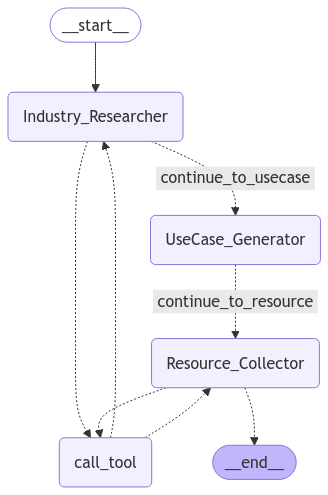

In [ ]:
# Initialize and configure the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("Industry_Researcher", industry_research_node)
workflow.add_node("UseCase_Generator", usecase_generator_node)
workflow.add_node("Resource_Collector", resource_collector_node)
workflow.add_node("call_tool", tool_node)

# Add edges
workflow.add_conditional_edges(
    "Industry_Researcher",
    router,
    {
        "continue_to_usecase": "UseCase_Generator",
        "call_tool": "call_tool",
    }
)

workflow.add_conditional_edges(
    "UseCase_Generator",
    router,
    {
        "continue_to_resource": "Resource_Collector",
    }
)

workflow.add_conditional_edges(
    "Resource_Collector",
    router,
    {
        "call_tool": "call_tool",
        "__end__": END
    }
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Industry_Researcher": "Industry_Researcher",
        "Resource_Collector": "Resource_Collector"
    }
)

# Set entry point
workflow.set_entry_point("Industry_Researcher")
agent_workflow = workflow.compile()

# Visualize the graph
from IPython.display import Image, display

display(Image(agent_workflow.get_graph().draw_mermaid_png()))


# **Test the Multi Agent System**

In [ ]:
prompt = "Conduct research on the medical industry,propose AI/ML use cases, and find relevant datasets for these use cases."

response = agent_workflow.invoke(
        {
            "messages": [('human', prompt)]
        }
)

In [ ]:
from IPython.display import display, Markdown

display(Markdown(response['messages'][-1].content))

FINAL ANSWER

### AI/ML Use Cases in the Medical Industry with Relevant Resources

#### Use Case 1: Predictive Analytics for Patient Outcomes
- **Problem Statement**: Healthcare providers often struggle to predict patient outcomes based on historical data, leading to suboptimal treatment plans and increased hospital readmissions.
- **Proposed Solution**: Implement a machine learning model that analyzes electronic health records (EHRs) to identify patterns and predict future health events, such as hospital readmissions or disease progression.
- **Expected Benefits**: Improved patient outcomes through personalized treatment plans, reduced hospital readmissions, and optimized resource allocation.

**Relevant Resources**:
1. **Kaggle Dataset**: [Healthcare Data Analysis and Predictive Modeling](https://www.kaggle.com/code/rishavwalde/healthcare-data-analysis-and-predictive-modeling)
   - **Content**: A notebook demonstrating predictive modeling techniques using healthcare data.
   - **Usage**: Can be used to develop predictive models for patient outcomes.

2. **HuggingFace Dataset**: [DiabetesQA](https://huggingface.co/datasets/infinite-dataset-hub/DiabetesQA)
   - **Content**: Dataset focusing on diabetes management and patient outcomes.
   - **Usage**: Useful for training predictive analytics models in healthcare.

3. **GitHub Repository**: [Predictive-Healthcare-Analytics-Modeling-Patient-Outcomes](https://github.com/AnthonyByansi/Predictive-Healthcare-Analytics-Modeling-Patient-Outcomes)
   - **Content**: Predictive models leveraging healthcare data to improve patient outcomes.
   - **Usage**: Provides a framework for developing predictive models based on various healthcare factors.

---

#### Use Case 2: Medical Imaging Diagnostics
- **Problem Statement**: Radiologists face challenges in accurately interpreting medical images due to the high volume of cases and the complexity of certain conditions.
- **Proposed Solution**: Develop an AI-powered diagnostic tool that uses convolutional neural networks (CNNs) to analyze medical images (e.g., X-rays, MRIs) and assist radiologists in detecting anomalies.
- **Expected Benefits**: Increased diagnostic accuracy, reduced time for image analysis, and enhanced radiologist productivity.

**Relevant Resources**:
1. **Kaggle Dataset**: [Medical Imaging Dataset for Brain Tumor Detection](https://www.kaggle.com/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection)
   - **Content**: Image dataset for object detection tasks in medicine.
   - **Usage**: Can be used to train models for detecting brain tumors in MRI scans.

2. **HuggingFace Dataset**: [CT-RATE](https://huggingface.co/datasets/ibrahimhamamci/CT-RATE)
   - **Content**: A dataset pairing chest CT volumes with corresponding radiology text reports.
   - **Usage**: Useful for developing models that analyze both images and associated reports.

3. **GitHub Repository**: [Medical-Imaging-Datasets](https://github.com/m-aryayi/Medical-Imaging-Datasets)
   - **Content**: A collection of publicly available medical imaging datasets.
   - **Usage**: Provides a comprehensive resource for researchers in medical imaging analysis.

---

#### Use Case 3: Personalized Medicine
- **Problem Statement**: Traditional treatment plans often adopt a one-size-fits-all approach, which may not be effective for all patients, especially in chronic diseases and cancer treatment.
- **Proposed Solution**: Utilize machine learning algorithms to analyze genetic, clinical, and lifestyle data to create personalized treatment plans tailored to individual patient profiles.
- **Expected Benefits**: Improved treatment efficacy, reduced side effects, and enhanced patient satisfaction.

**Relevant Resources**:
1. **Kaggle Dataset**: [Personalized Medicine: Redefining Cancer Treatment](https://www.kaggle.com/c/msk-redefining-cancer-treatment)
   - **Content**: A competition dataset for predicting genetic mutations related to cancer treatment.
   - **Usage**: Can be used to develop personalized treatment plans based on genetic data.

2. **HuggingFace Dataset**: [GenAIHealthCare](https://huggingface.co/datasets/infinite-dataset-hub/GenAIHealthCare)
   - **Content**: Dataset structured for developing predictive models in personalized patient care.
   - **Usage**: Useful for training models that assist in personalized treatment decisions.

3. **GitHub Repository**: [Personalized_Medicine-Recommendation_System](https://github.com/Luthrout/Personalized_Medicine-Recommendation_System)
   - **Content**: Code and data for a machine learning application that assists in prescribing medication based on individual characteristics.
   - **Usage**: Provides a framework for developing personalized medicine applications.

---

#### Use Case 4: Drug Discovery Acceleration
- **Problem Statement**: The drug discovery process is lengthy and costly, often taking years to bring a new drug to market.
- **Proposed Solution**: Implement AI algorithms to analyze biological data and predict the efficacy of potential drug candidates, thereby streamlining the drug discovery process.
- **Expected Benefits**: Reduced time and costs associated with drug development, increased success rates in clinical trials, and faster delivery of new therapies to patients.

**Relevant Resources**:
1. **Kaggle Dataset**: [Drug Discovery Data](https://www.kaggle.com/datasets/ruanrodriguez/drug-discovery-data)
   - **Content**: Mycobacterium Tuberculosis drug data.
   - **Usage**: Useful for training models in drug discovery.

2. **HuggingFace Dataset**: [MISATO-dataset](https://huggingface.co/t7morgen/misato-dataset)
   - **Content**: Dataset of protein-ligand complexes for structure-based drug discovery.
   - **Usage**: Can be used to develop models for predicting drug interactions.

3. **GitHub Repository**: [awesome-drug-discovery-knowledge-graphs](https://github.com/AstraZeneca/awesome-drug-discovery-knowledge-graphs)
   - **Content**: A collection of research papers, datasets, and software related to drug discovery.
   - **Usage**: Provides valuable resources for researchers in drug discovery.

---

#### Use Case 5: Remote Patient Monitoring
- **Problem Statement**: Chronic disease management often requires continuous monitoring, which can be challenging for healthcare providers and patients alike.
- **Proposed Solution**: Develop an AI-driven remote monitoring system that collects and analyzes patient health metrics (e.g., blood pressure, glucose levels) in real-time, alerting healthcare providers to any concerning changes.
- **Expected Benefits**: Improved chronic disease management, enhanced patient engagement, and reduced hospital visits.

**Relevant Resources**:
1. **Kaggle Dataset**: [Remote Patient Monitoring India Dataset](https://www.kaggle.com/datasets/ksabishek/remote-patient-monitoring-india-dataset/download?datasetVersionNumber=1)
   - **Content**: Dataset for remote patient monitoring in India.
   - **Usage**: Useful for developing models that monitor patient health metrics.

2. **HuggingFace Dataset**: [HospitalAdmissions](https://huggingface.co/datasets/infinite-dataset-hub/HospitalAdmissions)
   - **Content**: Dataset designed to assist in predicting patient outcomes based on admission details.
   - **Usage**: Can be used to develop predictive models for hospital admissions.

3. **GitHub Repository**: [Remote-Tracked-Patient-monitor](https://github.com/omaranwar21/Remote-Tracked-Patient-monitor)
   - **Content**: A comprehensive IoT project designed to monitor and manage real-time patient data.
   - **Usage**: Provides a framework for developing remote patient monitoring systems.

---

These use cases and resources illustrate the potential of AI and ML to transform the medical industry, improving patient care and operational efficiency while addressing key challenges faced by healthcare providers.

In [ ]:
prompt = "Please conduct a comprehensive analysis for Genpact Company. Generate AI/ML use cases and collect relevant resources."

response = agent_workflow.invoke(
        {
            "messages": [('human', prompt)]
        }
)

In [ ]:
from IPython.display import display, Markdown

display(Markdown(response['messages'][-1].content))

FINAL ANSWER

### Use Cases and Relevant Resources for Genpact

#### Use Case 1: Intelligent Customer Support Automation
- **Problem Statement**: Many organizations struggle with high customer service costs and long response times, leading to customer dissatisfaction.
- **Proposed Solution**: Implement AI-driven chatbots and virtual assistants that can handle common customer inquiries, provide instant responses, and escalate complex issues to human agents when necessary.
- **Expected Benefits**: 
  - Reduced operational costs by minimizing the need for human agents for routine inquiries.
  - Improved customer satisfaction through faster response times and 24/7 availability.
  - Enhanced data collection on customer interactions, leading to better insights and service improvements.

##### Relevant Resources
1. **Kaggle Dataset**: [Customer Support Ticket Dataset](https://www.kaggle.com/datasets/suraj520/customer-support-ticket-dataset)
   - **Content**: Contains customer inquiries related to hardware issues, software bugs, and other support topics.
   - **Usage**: Can be used to train models for automating responses to common customer queries.

2. **HuggingFace Model**: [Kustomer & Hugging Face](https://huggingface.co/case-studies/aws/kustomer)
   - **Content**: Model training runs in SageMaker by fine-tuning a pre-trained model for conversation classification.
   - **Usage**: Can be utilized to enhance customer service automation through improved classification of customer inquiries.

3. **GitHub Repository**: [AI Customer Support System](https://github.com/MrMaxMind/AI-Customer-Support-System)
   - **Content**: A project leveraging a GPT-2 model fine-tuned for customer support automation.
   - **Usage**: Provides a framework for generating relevant responses based on customer queries.

---

#### Use Case 2: Predictive Maintenance in Operations
- **Problem Statement**: Manufacturing and logistics companies often face unexpected equipment failures, leading to costly downtime and maintenance.
- **Proposed Solution**: Utilize machine learning algorithms to analyze historical equipment data and predict potential failures before they occur.
- **Expected Benefits**: 
  - Decreased downtime and maintenance costs through timely interventions.
  - Increased operational efficiency and productivity.
  - Enhanced asset lifespan and reliability.

##### Relevant Resources
1. **Kaggle Dataset**: [Predictive Maintenance Dataset](https://www.kaggle.com/datasets/hiimanshuagarwal/predictive-maintenance-dataset)
   - **Content**: A dataset for proactive identification of when maintenance should be performed.
   - **Usage**: Can be used to build predictive models for maintenance scheduling.

2. **HuggingFace Dataset**: [Predictive Maintenance](https://huggingface.co/datasets/Alignment-Lab-AI/evoltext8192)
   - **Content**: Data-driven insights for predictive maintenance applications.
   - **Usage**: Useful for training models to predict equipment failures.

3. **GitHub Repository**: [Predictive Maintenance Analysis and Modeling](https://github.com/MehmoodSheikh/PREDICTIVE-MAINTENANCE-ANALYSIS-AND-MODELING)
   - **Content**: A project leveraging machine learning to predict equipment failures.
   - **Usage**: Provides methodologies for implementing predictive maintenance strategies.

---

#### Use Case 3: Enhanced Risk Management
- **Problem Statement**: Financial institutions face challenges in identifying and mitigating risks due to the vast amount of data and regulatory requirements.
- **Proposed Solution**: Develop AI models that analyze transaction data in real-time to detect anomalies and potential fraud.
- **Expected Benefits**: 
  - Improved fraud detection rates and reduced financial losses.
  - Streamlined compliance processes, reducing the burden on human resources.
  - Enhanced decision-making capabilities through data-driven insights.

##### Relevant Resources
1. **Kaggle Dataset**: [Credit Risk Dataset](https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset/data)
   - **Content**: Contains credit history data for risk analysis.
   - **Usage**: Can be used to train models for assessing credit risk.

2. **HuggingFace Dataset**: [Operational Risk Management](https://huggingface.co/datasets/alvanlii/finance-textbooks)
   - **Content**: Data related to operational risk management.
   - **Usage**: Useful for developing models that assess and mitigate operational risks.

3. **GitHub Repository**: [Risk Management System](https://github.com/topics/risk-management)
   - **Content**: A PHP application for identifying risks and setting up mitigating actions.
   - **Usage**: Can be adapted for developing risk management solutions.

---

#### Use Case 4: Personalized Marketing Campaigns
- **Problem Statement**: Companies often struggle to create effective marketing campaigns that resonate with their target audience.
- **Proposed Solution**: Leverage machine learning algorithms to analyze customer data and behavior, enabling the creation of personalized marketing strategies.
- **Expected Benefits**: 
  - Increased conversion rates and customer engagement.
  - More efficient use of marketing budgets through targeted efforts.
  - Enhanced customer loyalty and retention through personalized experiences.

##### Relevant Resources
1. **Kaggle Dataset**: [Customer Sales Data](https://www.kaggle.com/datasets/manidevesh/customer-sales-data)
   - **Content**: Contains customer transaction data for targeted marketing.
   - **Usage**: Can be used to develop personalized marketing strategies.

2. **HuggingFace Model**: [AI Marketing Agents](https://github.com/Hk669/AI-Marketing-Agents)
   - **Content**: A project utilizing generative AI for personalized marketing campaigns.
   - **Usage**: Can automate the creation of personalized marketing content.

3. **GitHub Repository**: [Personalized Marketing Materials Generator](https://github.com/agarkra/Personalized-Marketing-Materials-Generator)
   - **Content**: End-to-end solution for generating personalized marketing materials.
   - **Usage**: Useful for creating customized marketing content based on customer data.

---

#### Use Case 5: Supply Chain Optimization
- **Problem Statement**: Supply chain disruptions can lead to significant financial losses and inefficiencies.
- **Proposed Solution**: Implement AI and machine learning to analyze supply chain data, forecast demand, and optimize inventory levels.
- **Expected Benefits**: 
  - Reduced inventory costs and improved cash flow.
  - Enhanced ability to respond to market changes and customer demands.
  - Increased overall supply chain efficiency and resilience.

##### Relevant Resources
1. **Kaggle Dataset**: [Supply Chain Data Set](https://www.kaggle.com/datasets/shivaiyer129/supply-chain-data-set)
   - **Content**: Data for visualizations and analytics in supply chain management.
   - **Usage**: Can be used for developing optimization models.

2. **HuggingFace Dataset**: [Supply Chain Optimization](https://huggingface.co/datasets/OpenCoder-LLM/fineweb-math-corpus)
   - **Content**: Data-driven insights for optimizing supply chain operations.
   - **Usage**: Useful for training models to enhance supply chain efficiency.

3. **GitHub Repository**: [Supply Chain Optimization](https://github.com/ankitrajsh/Supply-Chain-Optimization)
   - **Content**: Repository for applying ML to optimize supply chain management.
   - **Usage**: Provides methodologies for demand forecasting and inventory optimization.

--- 

These use cases and resources can significantly enhance Genpact's capabilities in AI and ML, driving operational efficiency and improving client outcomes.